In [2]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %%
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

# %% Load Data
train = pd.read_csv('/Users/ketki/Downloads/MJD_TRAIN_PROCESSED.csv')
test = pd.read_csv('/Users/ketki/Downloads/MJD_TEST_PROCESSED.csv')

train = train.dropna()  # Remove missing values

# Features & Target
train_data = train.drop(['id', 'energylabel', 'highavse', 'lowavse', 'truedcr', 'lq'], axis=1)
train_target = train['lq']

test_data = test.drop(['id', 'energylabel', 'highavse', 'lowavse', 'truedcr', 'lq'], axis=1)
test_target = test['lq']

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
train_data, train_target = smote.fit_resample(train_data, train_target)

# %% Train Decision Tree Model
model = DecisionTreeClassifier(
    random_state=42, 
    max_depth=6, 
    min_samples_split=10, 
    min_samples_leaf=5
)

model.fit(train_data, train_target)

# %% Evaluate on Test Set
pred = model.predict(test_data)
print("Decision Tree Classifier Report:")
print(classification_report(test_target, pred))
print(f"Accuracy: {accuracy_score(test_target, pred)}")

# %% Feature Importance
features = model.feature_importances_
names = train_data.columns

print("\nFeature Importance:")
for name, importance in zip(names, features):
    print(f"{name}: {importance:.4f}")

# %% Cross-Validation
cv_scores = cross_val_score(model, train_data, train_target, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# %% Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2
)

random_search.fit(train_data, train_target)

print("\nBest Parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print("Best Accuracy Score: ", random_search.best_score_)


Decision Tree Classifier Report:
              precision    recall  f1-score   support

       False       0.07      0.91      0.14      3160
        True       1.00      0.91      0.95    386840

    accuracy                           0.91    390000
   macro avg       0.54      0.91      0.54    390000
weighted avg       0.99      0.91      0.94    390000

Accuracy: 0.9075410256410257

Feature Importance:
tdrift: 0.0062
tdrift50: 0.0370
tdrift10: 0.3295
rea: 0.4702
dcr: 0.0005
peakindex: 0.0171
peakvalue: 0.0007
tailslope: 0.0003
currentamp: 0.0275
lfpr: 0.0014
lq80: 0.0259
areagrowthrate: 0.0029
inflection point: 0.0000
risingedgeslope: 0.0808

Cross-Validation Accuracy: 0.9195 ± 0.0004
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END criterion=gini, max_depth=3, min_samples_leaf=8, min_samples_split=10; total time=  29.5s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=8, min_samples_split=10; total time=  31.6s
[CV] END criterion=gini, max_depth=3, min_s

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# %% Load Data
train = pd.read_csv('/Users/ketki/Downloads/MJD_TRAIN_PROCESSED.csv')
test = pd.read_csv('/Users/ketki/Downloads/MJD_TEST_PROCESSED.csv')

train = train.dropna()  # Remove missing values

# Features & Target
train_data = train.drop(['id', 'energylabel', 'highavse', 'lowavse', 'truedcr', 'lq'], axis=1)
train_target = train['lq']

test_data = test.drop(['id', 'energylabel', 'highavse', 'lowavse', 'truedcr', 'lq'], axis=1)
test_target = test['lq']


rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(train_data, train_target)
rf_pred = rf_model.predict(test_data)
print(f"Accuracy: {accuracy_score(test_target, rf_pred)}")

Accuracy: 0.8178589743589744


/var/folders/l9/2v23khpn5r75f0wfrppwlb0h0000gp/T/ipykernel_1406/1116260542.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance, y=sorted_features, palette="viridis")


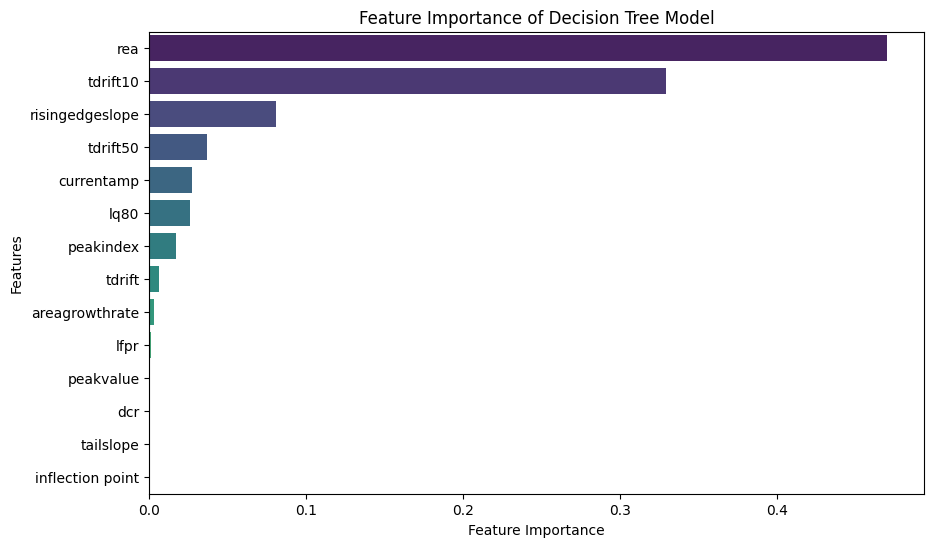

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_idx = np.argsort(features)[::-1]
sorted_features = [names[i] for i in sorted_idx]
sorted_importance = features[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance of Decision Tree Model")
plt.show()

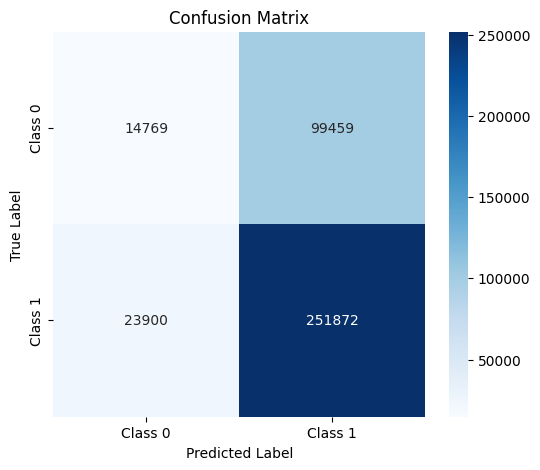

In [4]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_target, pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics
precision = precision_score(test_target, pred)
recall = recall_score(test_target, pred)
f1 = f1_score(test_target, pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7169
Recall: 0.9133
F1 Score: 0.8033
